<a href="https://colab.research.google.com/github/teteumac/Acoplamento-Quartico-Anomalo/blob/main/WWCEP_LightGBM_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [523]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [524]:
!python3 -m pip install mplhep

In [525]:
import lightgbm as lgb
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import mplhep as hep
from matplotlib.colors import ListedColormap
from sklearn.metrics import make_scorer,fbeta_score,precision_score,recall_score,accuracy_score,log_loss,roc_auc_score,classification_report,f1_score,confusion_matrix,roc_curve,precision_recall_curve,average_precision_score,plot_precision_recall_curve,plot_roc_curve

In [526]:
PATH = '/content/gdrive/My Drive/Colab Notebooks/output_for_LGBM/'

In [527]:
plt.style.use(hep.style.ROOT)

# **Signal**


In [528]:
def open_file_signal( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset )
        array_cut = ( array[:,13] > 0 ) & ( array[:,14] > 0 )  # Corte no xi1 e no xi2
        DataSet = array[array_cut]   
        DataSet = np.delete(DataSet,30,1)
        dataframe = pd.DataFrame( DataSet , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
    'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks', 'PUWeight',
    'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2', 'Norm_MC', 'Mx','Yx', 'Mww/Mx', 'weight'] )
        return dataframe

## **Background**

In [529]:
def open_file_back( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset )
        array_cut = ( array[:,13] > 0 ) & ( array[:,14] > 0 )  # Corte no xi1 e no xi2
        DataSet = array[array_cut]        
        dataframe = pd.DataFrame( array , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
    'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks', 'PUWeight',
    'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2', 'Norm_MC', 'Mx','Yx', 'Mww/Mx', 'weight'] )
        return dataframe

# **Dados**

In [530]:
def open_file_dados( file ):
    df = None
    with h5py.File( file , 'r' ) as f:
        dset = f[ 'dados' ]
        array = np.array( dset )
        array_cut = ( array[:,13] > 0) & ( array[:,14] > 0 )  # Corte no xi1 e no xi2
        DataSet = array[array_cut]        
        dataframe = pd.DataFrame( array , columns = ['Mww','Pt_W_lep','dPhi_Whad_Wlep','dPhi_jatos_MET','jetAK8_pt','jetAK8_eta',
    'jetAK8_prunedMass','jetAK8_tau21','METPt','muon_pt','muon_eta','ExtraTracks', 'PUWeight',
    'xi1','xi2','anguloX1', 'anguloX2', 'anguloY1','anguloY2', 'rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2', 'Mx','Yx', 'Mww/Mx'] )
        return dataframe

Selecionando as colunas que não serão usadas para o treinamento

In [531]:
Drop_Columns = ['anguloX1','anguloX2','Norm_MC','anguloY1','label','anguloY2','rpid1','rpid2','arm1','arm2','ismultirp1','ismultirp2','PUWeight', 'weight']

## Arquivos de Sinal 

In [532]:
SM =       open_file_signal(PATH + 'DataSet_SM_multiRP.h5')
ANOMALO1 = open_file_signal(PATH + 'DataSet_ANOMALO1_multiRP.h5')
ANOMALO2 = open_file_signal(PATH + 'DataSet_ANOMALO2_multiRP.h5')
ANOMALO3 = open_file_signal(PATH + 'DataSet_ANOMALO3_multiRP.h5')
ANOMALO4 = open_file_signal(PATH + 'DataSet_ANOMALO4_multiRP.h5')
ANOMALO5 = open_file_signal(PATH + 'DataSet_ANOMALO5_multiRP.h5')
ANOMALO6 = open_file_signal(PATH + 'DataSet_ANOMALO6_multiRP.h5')
ANOMALO7 = open_file_signal(PATH + 'DataSet_ANOMALO7_multiRP.h5')
ANOMALO8 = open_file_signal(PATH + 'DataSet_ANOMALO8_multiRP.h5')

Criando Label de Sinal

Anômalos --> 1

Modelo Padrão --> 2

In [533]:
label_signal1  = pd.DataFrame( [1]*len( ANOMALO1 ) )
label_signal2  = pd.DataFrame( [1]*len( ANOMALO2 ) )
label_signal3  = pd.DataFrame( [1]*len( ANOMALO3 ) )
label_signal4  = pd.DataFrame( [1]*len( ANOMALO4 ) )
label_signal5  = pd.DataFrame( [1]*len( ANOMALO5 ) )
label_signal6  = pd.DataFrame( [1]*len( ANOMALO6 ) )
label_signal7  = pd.DataFrame( [1]*len( ANOMALO7 ) )
label_signal8  = pd.DataFrame( [1]*len( ANOMALO8 ) )
label_signalSM = pd.DataFrame( [2]*len( SM ) )

Concatenando os Label criados com o DataFrame dos Sinais já obtidos

In [534]:
SM = pd.concat( [ SM, label_signalSM ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Standard Model --> ', SM.shape)

ANOMALO1 = pd.concat( [ ANOMALO1, label_signal1 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 1 --> ', ANOMALO1.shape)

ANOMALO2 = pd.concat( [ ANOMALO2, label_signal2 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 2 --> ', ANOMALO2.shape)

ANOMALO3 = pd.concat( [ ANOMALO3, label_signal3 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 3 --> ', ANOMALO3.shape)

ANOMALO4 = pd.concat( [ ANOMALO4, label_signal4 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 4 --> ', ANOMALO4.shape)

ANOMALO5 = pd.concat( [ ANOMALO5, label_signal5 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 5 --> ', ANOMALO5.shape)

ANOMALO6 = pd.concat( [ ANOMALO6, label_signal6 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 6 --> ', ANOMALO6.shape)

ANOMALO7 = pd.concat( [ ANOMALO7, label_signal7 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 7 --> ', ANOMALO7.shape)

ANOMALO8 = pd.concat( [ ANOMALO8, label_signal8 ], axis = 1 ).rename(columns={0: 'label'})
print('Shape for Anomalo 8 --> ', ANOMALO8.shape)

Shape for Standard Model -->  (122, 31)
Shape for Anomalo 1 -->  (1902, 31)
Shape for Anomalo 2 -->  (192, 31)
Shape for Anomalo 3 -->  (511, 31)
Shape for Anomalo 4 -->  (885, 31)
Shape for Anomalo 5 -->  (189, 31)
Shape for Anomalo 6 -->  (335, 31)
Shape for Anomalo 7 -->  (804, 31)
Shape for Anomalo 8 -->  (1965, 31)


In [535]:
ANOMALO8

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,muon_eta,ExtraTracks,PUWeight,xi1,xi2,anguloX1,anguloX2,anguloY1,anguloY2,rpid1,rpid2,arm1,arm2,ismultirp1,ismultirp2,Norm_MC,Mx,Yx,Mww/Mx,weight,label
0,1091.432084,510.926240,3.117518,3.060315,512.252382,0.588001,64.387497,0.385876,438.583160,77.243584,0.073565,0.0,1.349845,0.066678,0.128240,4.473032e-06,5.233575e-06,7.134227e-05,0.000032,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1202.119322,-0.327013,0.907923,2.364661,1
1,843.338288,185.603543,-3.102502,-3.119897,361.148906,0.115613,74.811493,0.622806,335.840332,150.299545,0.031626,1.0,0.129138,0.089900,0.051922,3.888760e-05,-2.080604e-07,-9.562282e-06,-0.000048,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,888.177667,0.274479,0.949515,2.353514,1
2,1319.880134,424.903596,3.133700,-3.106809,577.987082,0.316161,72.322922,0.267715,550.564819,127.344925,0.342919,4.0,0.129138,0.099210,0.107669,-4.699331e-05,-4.442597e-06,3.595248e-06,0.000055,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1343.587218,-0.040913,0.982355,2.386964,1
3,1364.655111,622.270681,3.136570,-3.033910,624.743568,0.387960,76.007668,0.466884,327.226440,299.390808,0.421632,0.0,1.343057,0.104374,0.096793,-3.771568e-05,-2.569298e-05,-3.636945e-07,-0.000012,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1306.658428,0.037704,1.044385,2.394219,1
4,1119.523438,564.435780,3.093096,3.035046,541.182527,0.163284,76.508545,0.164459,408.106262,158.792099,0.316088,0.0,1.565053,0.061709,0.100642,6.896975e-07,2.888216e-05,-8.181659e-05,0.000065,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1024.486799,-0.244573,1.092765,2.386964,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,1311.696885,671.589782,3.122500,2.996087,625.578310,0.005898,62.400845,0.405058,332.338867,344.460693,0.134200,0.0,0.698613,0.092835,0.106647,-2.068080e-05,5.192711e-05,3.083174e-05,0.000009,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1293.526575,-0.069351,1.014047,2.360668,1
1961,1112.204516,542.310188,-3.135007,-2.993324,553.858281,0.168496,81.520454,0.591548,226.590561,319.595825,0.021954,0.0,1.361949,0.097056,0.073102,-5.896850e-05,1.122251e-04,1.084849e-05,-0.000003,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1095.013808,0.141713,1.015699,2.360668,1
1962,1217.282676,578.761873,-3.026591,-3.021236,568.249097,0.323562,70.277191,0.566906,500.769073,78.046066,0.314952,0.0,1.279082,0.086246,0.122762,-5.149474e-05,3.521360e-05,-3.716353e-05,-0.000051,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1337.661771,-0.176520,0.910008,2.398269,1
1963,1180.496761,578.137409,-3.092037,-2.967567,582.939922,0.139543,57.727821,0.525836,214.799545,365.972504,0.121665,0.0,1.081116,0.111366,0.125129,-3.586794e-05,-4.195071e-05,3.532022e-05,-0.000010,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1534.614287,-0.058260,0.769247,2.360668,1


# Arquivo de Background

In [536]:
data_set_back_multirp = open_file_back( PATH + 'DataSet_back_multiRP.h5' )

Criando Label para arquivos de Background

O Background foi unificado num Dataset só

In [537]:
label_back = pd.DataFrame( [0]*len( data_set_back_multirp ) )
data_set_back_multirp = pd.concat( [ data_set_back_multirp, label_back ], axis = 1 ).rename(columns={0: 'label'})
data_set_back_multirp

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,muon_eta,ExtraTracks,PUWeight,xi1,xi2,anguloX1,anguloX2,anguloY1,anguloY2,rpid1,rpid2,arm1,arm2,ismultirp1,ismultirp2,Norm_MC,Mx,Yx,Mww/Mx,weight,label
0,491.252688,86.378461,2.942407,3.021721,261.917484,0.554624,14.697449,0.829036,148.862837,63.127998,0.532020,41.0,1.814980,0.079192,0.043149,-0.000059,0.000001,-0.000016,0.000081,-999.0,-999.0,0.0,1.0,1.0,1.0,0.103731,759.921640,0.303606,0.646452,0.960596,0
1,430.081017,64.076184,-2.641155,-0.312037,275.706346,0.736420,39.297512,0.725625,60.707984,114.636230,0.142139,63.0,0.924064,0.069609,0.100977,-0.000084,-0.000049,0.000090,0.000012,-999.0,-999.0,0.0,1.0,1.0,1.0,0.103731,1089.903226,-0.186003,0.394605,0.690887,0
2,447.463233,160.713092,-3.122101,2.054580,223.577064,1.772923,9.523066,0.864771,65.295067,143.854553,2.028264,72.0,1.565053,0.074003,0.136734,0.000008,0.000005,-0.000002,-0.000079,-999.0,-999.0,0.0,1.0,1.0,1.0,0.103731,1307.690996,-0.306967,0.342178,0.656289,0
3,577.355761,49.396053,1.720625,-2.052942,245.312010,1.243477,10.626281,0.823483,49.321103,93.829674,1.179348,74.0,1.279082,0.066402,0.097216,-0.000003,0.000006,-0.000078,-0.000026,-999.0,-999.0,0.0,1.0,1.0,1.0,0.103731,1044.485923,-0.190607,0.552765,0.613605,0
4,380.210620,109.381509,3.027313,1.588565,206.520500,0.822602,53.864925,0.652008,50.221132,114.192505,0.439985,34.0,0.924064,0.060232,0.082523,0.000030,-0.000012,0.000075,-0.000054,-999.0,-999.0,0.0,1.0,1.0,1.0,0.103731,916.527089,-0.157441,0.414838,1.139423,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594962,537.129669,186.942000,2.559761,2.472331,334.481800,1.549886,80.579109,0.565595,135.458648,53.328995,1.532498,55.0,0.862713,0.091598,0.085008,0.000039,0.000110,-0.000071,-0.000132,-999.0,-999.0,0.0,1.0,1.0,1.0,0.002030,1147.143176,0.037331,0.468232,0.743241,0
594963,705.793674,178.515904,-2.753909,2.044226,359.830952,1.818925,58.470512,0.571189,66.057639,184.964096,1.130062,29.0,0.002163,0.077920,0.082246,-0.000068,0.000051,-0.000065,-0.000057,-999.0,-999.0,0.0,1.0,1.0,1.0,0.002030,1040.700326,-0.027016,0.678191,1.103023,0
594964,626.186715,178.440028,3.125389,2.915112,369.224084,1.538476,95.430534,0.461589,48.222325,131.665207,0.296539,103.0,0.462432,0.107012,0.107105,-0.000036,-0.000052,-0.000208,0.000029,-999.0,-999.0,0.0,1.0,1.0,1.0,0.002030,1391.761906,-0.000433,0.449924,0.568083,0
594965,465.720111,59.680116,2.555086,-0.149531,407.136036,0.396974,29.358212,0.669782,48.142368,105.288864,0.846493,61.0,1.349845,0.094266,0.104169,0.000035,-0.000057,-0.000038,-0.000081,-999.0,-999.0,0.0,1.0,1.0,1.0,0.002030,1288.220684,-0.049951,0.361522,0.680845,0


Concatenando o background e o modelo padrão com cada anômalo 

In [538]:
Dataset_Signal_Back1 = pd.concat( [ ANOMALO1 , data_set_back_multirp, SM  ], axis = 0, sort = False )
#Dataset_Signal_Back2  = pd.concat( [ ANOMALO2 , data_set_back_multirp, SM  ], axis = 0, sort = False )
#Dataset_Signal_Back3  = pd.concat( [ ANOMALO3 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back4  = pd.concat( [ ANOMALO4 , data_set_back_multirp, SM  ], axis = 0, sort = False )
#Dataset_Signal_Back5  = pd.concat( [ ANOMALO5 , data_set_back_multirp, SM  ], axis = 0, sort = False )
#Dataset_Signal_Back6  = pd.concat( [ ANOMALO6 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back7  = pd.concat( [ ANOMALO7 , data_set_back_multirp, SM  ], axis = 0, sort = False )
Dataset_Signal_Back8  = pd.concat( [ ANOMALO8 , data_set_back_multirp, SM  ], axis = 0, sort = False )


In [539]:
Dataset_Signal_Back8

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,muon_eta,ExtraTracks,PUWeight,xi1,xi2,anguloX1,anguloX2,anguloY1,anguloY2,rpid1,rpid2,arm1,arm2,ismultirp1,ismultirp2,Norm_MC,Mx,Yx,Mww/Mx,weight,label
0,1091.432084,510.926240,3.117518,3.060315,512.252382,0.588001,64.387497,0.385876,438.583160,77.243584,0.073565,0.0,1.349845,0.066678,0.128240,4.473032e-06,5.233575e-06,7.134227e-05,0.000032,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1202.119322,-0.327013,0.907923,2.364661,1
1,843.338288,185.603543,-3.102502,-3.119897,361.148906,0.115613,74.811493,0.622806,335.840332,150.299545,0.031626,1.0,0.129138,0.089900,0.051922,3.888760e-05,-2.080604e-07,-9.562282e-06,-0.000048,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,888.177667,0.274479,0.949515,2.353514,1
2,1319.880134,424.903596,3.133700,-3.106809,577.987082,0.316161,72.322922,0.267715,550.564819,127.344925,0.342919,4.0,0.129138,0.099210,0.107669,-4.699331e-05,-4.442597e-06,3.595248e-06,0.000055,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1343.587218,-0.040913,0.982355,2.386964,1
3,1364.655111,622.270681,3.136570,-3.033910,624.743568,0.387960,76.007668,0.466884,327.226440,299.390808,0.421632,0.0,1.343057,0.104374,0.096793,-3.771568e-05,-2.569298e-05,-3.636945e-07,-0.000012,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1306.658428,0.037704,1.044385,2.394219,1
4,1119.523438,564.435780,3.093096,3.035046,541.182527,0.163284,76.508545,0.164459,408.106262,158.792099,0.316088,0.0,1.565053,0.061709,0.100642,6.896975e-07,2.888216e-05,-8.181659e-05,0.000065,-999.0,-999.0,0.0,1.0,1.0,1.0,0.007147,1024.486799,-0.244573,1.092765,2.386964,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,770.047034,272.129345,3.010626,2.907466,219.726091,0.835990,70.315643,0.384842,111.869804,161.266266,1.126630,0.0,0.179067,0.049349,0.085079,8.053867e-06,-3.596184e-05,5.527626e-05,0.000065,-999.0,-999.0,0.0,1.0,1.0,1.0,0.001922,842.355430,-0.272333,0.914159,2.244747,2
118,1019.790786,423.951829,3.135045,2.918155,475.101373,0.664115,79.816910,0.354806,194.450302,237.768234,0.295437,10.0,0.756504,0.064515,0.096102,2.650066e-05,4.097372e-05,-7.455780e-06,-0.000022,-999.0,-999.0,0.0,1.0,1.0,1.0,0.001922,1023.620451,-0.199255,0.996259,1.368629,2
119,724.126785,241.598397,3.103619,2.906768,240.853464,0.692049,5.131672,0.760466,68.370445,175.059830,1.243215,1.0,0.806324,0.050599,0.096067,1.077732e-04,5.070557e-06,4.918862e-05,-0.000093,-999.0,-999.0,0.0,1.0,1.0,1.0,0.001922,906.358744,-0.320561,0.798941,2.436351,2
120,542.373485,95.696669,2.922248,3.025133,267.990246,0.007094,60.392857,0.303872,193.396515,98.696465,0.101461,1.0,1.361949,0.051159,0.046186,3.969868e-05,-1.542333e-05,4.214370e-05,0.000078,-999.0,-999.0,0.0,1.0,1.0,1.0,0.001922,631.911057,0.051133,0.858307,2.364661,2


# **Dados**

In [540]:
data_set_dados_multirp = open_file_dados( PATH + 'DataSet_dados_multiRP.h5' )
data_set_dados_multirp

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,muon_eta,ExtraTracks,PUWeight,xi1,xi2,anguloX1,anguloX2,anguloY1,anguloY2,rpid1,rpid2,arm1,arm2,ismultirp1,ismultirp2,Mx,Yx,Mww/Mx
0,426.046862,129.979211,-2.821701,2.897748,211.243358,1.603526,38.754257,0.429928,100.965467,70.022240,0.780295,46.0,1.269749e-321,0.120173,0.052542,-1.062199e-05,0.000000e+00,0.000011,0.000138,-999.0,2.0,0.0,-999.0,1.0,1.0,1033.002472,0.413656,0.412435
1,1760.806357,178.409060,2.153189,2.402611,503.817237,1.288167,84.660660,0.542487,95.728902,88.842651,1.799131,57.0,1.269749e-321,0.054662,0.065396,1.595027e-04,0.000000e+00,-0.000013,-0.000115,-999.0,103.0,1.0,-999.0,1.0,1.0,777.251586,-0.089644,2.265427
2,545.354901,263.380052,-3.069058,2.983786,264.226996,1.553682,41.875698,0.680491,153.578894,119.134239,1.517383,46.0,1.269749e-321,0.107407,0.082358,8.644894e-06,-8.448615e-08,-0.000035,0.000025,3.0,102.0,0.0,1.0,1.0,1.0,1222.678929,0.132774,0.446033
3,420.297633,101.908789,-3.041800,2.144121,255.434097,1.284160,47.696346,0.713127,60.576425,91.784966,0.652207,57.0,1.269749e-321,0.128126,0.069400,-1.518105e-05,0.000000e+00,-0.000021,0.000059,-999.0,102.0,0.0,-999.0,1.0,1.0,1225.863681,0.306562,0.342858
4,758.866801,414.932647,-3.087606,-3.136166,326.036373,0.270669,30.374830,0.647265,344.575481,72.713234,0.577268,36.0,1.269749e-321,0.095670,0.138338,-2.892127e-05,0.000000e+00,0.000100,0.000040,-999.0,2.0,0.0,-999.0,1.0,1.0,1495.556856,-0.184398,0.507414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30626,696.546949,239.871332,3.055661,-3.041997,321.312530,0.638756,100.389801,0.445308,70.341797,171.229019,1.642718,72.0,0.000000e+00,0.139072,0.119325,-5.288560e-05,0.000000e+00,-0.000010,-0.000028,-999.0,102.0,0.0,-999.0,1.0,1.0,1674.670597,0.076572,0.415931
30627,484.836738,206.579361,-2.977614,3.115148,216.535329,0.323150,47.790222,0.434432,41.435763,166.077866,1.064500,28.0,0.000000e+00,0.056472,0.074889,0.000000e+00,0.000000e+00,-0.000088,0.000047,-999.0,102.0,1.0,-999.0,1.0,1.0,845.417066,-0.141131,0.573488
30628,639.740313,260.790097,-3.039377,2.561025,324.888369,0.649707,39.344273,0.672074,54.160476,221.424194,1.354916,24.0,0.000000e+00,0.094114,0.100330,-3.444671e-05,0.000000e+00,0.000044,0.000053,-999.0,2.0,1.0,-999.0,1.0,1.0,1263.239911,-0.031982,0.506428
30629,592.811854,109.831797,-3.078840,-2.506831,237.695641,0.860805,6.562993,0.683357,40.710925,78.747948,1.050521,37.0,0.000000e+00,0.065611,0.058206,4.717379e-05,0.000000e+00,0.000002,-0.000020,-999.0,102.0,0.0,-999.0,1.0,1.0,803.369075,0.059880,0.737907


In [541]:
from sklearn.model_selection import train_test_split

# Fazendo a mistura dos Dataset's

In [542]:
test_size = 0.30
DataSet_Train1, DataSet_Test1 = train_test_split( Dataset_Signal_Back1, test_size = test_size, random_state = 41 )
#DataSet_Train2, DataSet_Test2 = train_test_split( Dataset_Signal_Back2, test_size = test_size, random_state = 0 )
#DataSet_Train3, DataSet_Test3 = train_test_split( Dataset_Signal_Back3, test_size = test_size, random_state = 0 )
DataSet_Train4, DataSet_Test4 = train_test_split( Dataset_Signal_Back4, test_size = test_size, random_state = 42 )
#DataSet_Train5, DataSet_Test5 = train_test_split( Dataset_Signal_Back5, test_size = test_size, random_state = 0 )
#DataSet_Train6, DataSet_Test6 = train_test_split( Dataset_Signal_Back6, test_size = test_size, random_state = 0 )
DataSet_Train7, DataSet_Test7 = train_test_split( Dataset_Signal_Back7, test_size = test_size, random_state = 41 )
DataSet_Train8, DataSet_Test8 = train_test_split( Dataset_Signal_Back8, test_size = test_size, random_state = 41 )

# Selecionando os Labels 

In [543]:
y_train1 = DataSet_Train1['label']
y_test1  = DataSet_Test1['label']

#y_train2 = DataSet_Train2['label']
#y_test2  = DataSet_Test2['label']

#y_train3 = DataSet_Train3['label']
#y_test3  = DataSet_Test3['label']

y_train4 = DataSet_Train4['label']
y_test4  = DataSet_Test4['label']

#y_train5 = DataSet_Train5['label']
#y_test5  = DataSet_Test5['label']

#y_train6 = DataSet_Train6['label']
#y_test6  = DataSet_Test6['label']

y_train7 = DataSet_Train7['label']
y_test7  = DataSet_Test7['label']

y_train8 = DataSet_Train8['label']
y_test8  = DataSet_Test8['label']

# Extraindo os Pesos

In [544]:
print('--- Weight Anomalo 8 --- \n')
DataSet_Test8_weight_signal = DataSet_Test8[DataSet_Test8['label']==1]['Norm_MC'] * DataSet_Test8[DataSet_Test8['label']==1]['PUWeight'] * DataSet_Test8[DataSet_Test8['label']==1]['weight'] 
DataSet_TestSM8_weight_signal = DataSet_Test8[DataSet_Test8['label']==2]['Norm_MC'] * DataSet_Test8[DataSet_Test8['label']==2]['PUWeight'] * DataSet_Test8[DataSet_Test8['label']==2]['weight'] 
DataSet_Test8_weight_backgr = DataSet_Test8[DataSet_Test8['label']==0]['Norm_MC'] * DataSet_Test8[DataSet_Test8['label']==0]['PUWeight'] * DataSet_Test8[DataSet_Test8['label']==0]['weight'] 

DataSet_Train8_weight_signal = DataSet_Train8[DataSet_Train8['label']==1]['Norm_MC'] * DataSet_Train8[DataSet_Train8['label']==1]['PUWeight'] * DataSet_Train8[DataSet_Train8['label']==1]['weight']
DataSet_TrainSM8_weight_signal = DataSet_Train8[DataSet_Train8['label']==2]['Norm_MC'] * DataSet_Train8[DataSet_Train8['label']==2]['PUWeight'] * DataSet_Train8[DataSet_Train8['label']==2]['weight']
DataSet_Train8_weight_backgr = DataSet_Train8[DataSet_Train8['label']==0]['Norm_MC'] * DataSet_Train8[DataSet_Train8['label']==0]['PUWeight'] * DataSet_Train8[DataSet_Train8['label']==0]['weight'] 

DataSet_Test8_weight = DataSet_Test8['Norm_MC'] * DataSet_Test8['PUWeight'] * DataSet_Test8['weight']

print( 'Shape Test Signal', DataSet_Test8_weight_signal.shape)
print( 'Shape Test SM', DataSet_TestSM8_weight_signal.shape)
print( 'Shape Test Background', DataSet_Test8_weight_backgr.shape, '\n')

print('--- Weight Anomalo 7 --- \n')

DataSet_Test7_weight_signal = DataSet_Test7[DataSet_Test7['label']==1]['Norm_MC'] * DataSet_Test7[DataSet_Test7['label']==1]['PUWeight'] * DataSet_Test7[DataSet_Test7['label']==1]['weight'] 
DataSet_TestSM7_weight_signal = DataSet_Test7[DataSet_Test7['label']==2]['Norm_MC'] * DataSet_Test7[DataSet_Test7['label']==2]['PUWeight'] * DataSet_Test7[DataSet_Test7['label']==2]['weight'] 
DataSet_Test7_weight_backgr = DataSet_Test7[DataSet_Test7['label']==0]['Norm_MC'] * DataSet_Test7[DataSet_Test7['label']==0]['PUWeight'] * DataSet_Test7[DataSet_Test7['label']==0]['weight'] 

DataSet_Train7_weight_signal = DataSet_Train7[DataSet_Train7['label']==1]['Norm_MC'] * DataSet_Train7[DataSet_Train7['label']==1]['PUWeight'] * DataSet_Train7[DataSet_Train7['label']==1]['weight']
DataSet_TrainSM7_weight_signal = DataSet_Train7[DataSet_Train7['label']==2]['Norm_MC'] * DataSet_Train7[DataSet_Train7['label']==2]['PUWeight'] * DataSet_Train7[DataSet_Train7['label']==2]['weight']
DataSet_Train7_weight_backgr = DataSet_Train7[DataSet_Train7['label']==0]['Norm_MC'] * DataSet_Train7[DataSet_Train7['label']==0]['PUWeight'] * DataSet_Train7[DataSet_Train7['label']==0]['weight'] 

DataSet_Test7_weight = DataSet_Test7['Norm_MC'] * DataSet_Test7['PUWeight'] * DataSet_Test7['weight']

print( 'Shape Test Signal',  DataSet_Test7_weight_signal.shape)
print( 'Shape Test SM', DataSet_TestSM7_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test7_weight_backgr.shape, '\n')

print('--- Weight Anomalo 1 --- \n')

DataSet_Test1_weight_signal = DataSet_Test1[DataSet_Test1['label']==1]['Norm_MC'] * DataSet_Test1[DataSet_Test1['label']==1]['PUWeight'] * DataSet_Test1[DataSet_Test1['label']==1]['weight'] 
DataSet_TestSM1_weight_signal = DataSet_Test1[DataSet_Test1['label']==2]['Norm_MC'] * DataSet_Test1[DataSet_Test1['label']==2]['PUWeight'] * DataSet_Test1[DataSet_Test1['label']==2]['weight'] 
DataSet_Test1_weight_backgr = DataSet_Test1[DataSet_Test1['label']==0]['Norm_MC'] * DataSet_Test1[DataSet_Test1['label']==0]['PUWeight'] * DataSet_Test1[DataSet_Test1['label']==0]['weight'] 

DataSet_Train1_weight_signal = DataSet_Train1[DataSet_Train1['label']==1]['Norm_MC'] * DataSet_Train1[DataSet_Train1['label']==1]['PUWeight'] * DataSet_Train1[DataSet_Train1['label']==1]['weight']
DataSet_TrainSM1_weight_signal = DataSet_Train1[DataSet_Train1['label']==2]['Norm_MC'] * DataSet_Train1[DataSet_Train1['label']==2]['PUWeight'] * DataSet_Train1[DataSet_Train1['label']==2]['weight']
DataSet_Train1_weight_backgr = DataSet_Train1[DataSet_Train1['label']==0]['Norm_MC'] * DataSet_Train1[DataSet_Train1['label']==0]['PUWeight'] * DataSet_Train1[DataSet_Train1['label']==0]['weight'] 

DataSet_Test1_weight = DataSet_Test1['Norm_MC'] * DataSet_Test1['PUWeight'] * DataSet_Test1['weight']

print( 'Shape Test Signal', DataSet_Test1_weight_signal.shape)
print('Shape Test SM',  DataSet_TestSM1_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test1_weight_backgr.shape, '\n')


print('--- Weight Anomalo 4 --- \n')

DataSet_Test4_weight_signal = DataSet_Test4[DataSet_Test4['label']==1]['Norm_MC'] * DataSet_Test4[DataSet_Test4['label']==1]['PUWeight'] * DataSet_Test4[DataSet_Test4['label']==1]['weight'] 
DataSet_TestSM4_weight_signal = DataSet_Test4[DataSet_Test4['label']==2]['Norm_MC'] * DataSet_Test4[DataSet_Test4['label']==2]['PUWeight'] * DataSet_Test4[DataSet_Test4['label']==2]['weight'] 
DataSet_Test4_weight_backgr = DataSet_Test4[DataSet_Test4['label']==0]['Norm_MC'] * DataSet_Test4[DataSet_Test4['label']==0]['PUWeight'] * DataSet_Test4[DataSet_Test4['label']==0]['weight'] 

DataSet_Train4_weight_signal = DataSet_Train4[DataSet_Train4['label']==1]['Norm_MC'] * DataSet_Train4[DataSet_Train4['label']==1]['PUWeight'] * DataSet_Train4[DataSet_Train4['label']==1]['weight']
DataSet_TrainSM4_weight_signal = DataSet_Train4[DataSet_Train4['label']==2]['Norm_MC'] * DataSet_Train4[DataSet_Train4['label']==2]['PUWeight'] * DataSet_Train4[DataSet_Train4['label']==2]['weight']
DataSet_Train4_weight_backgr = DataSet_Train4[DataSet_Train4['label']==0]['Norm_MC'] * DataSet_Train4[DataSet_Train4['label']==0]['PUWeight'] * DataSet_Train4[DataSet_Train4['label']==0]['weight'] 

DataSet_Test4_weight = DataSet_Test4['Norm_MC'] * DataSet_Test4['PUWeight'] * DataSet_Test4['weight']

print( 'Shape Test SM' , DataSet_Test4_weight_signal.shape)
print( 'Shape Test SM', DataSet_TestSM4_weight_signal.shape)
print( 'Shape Test Background' , DataSet_Test4_weight_backgr.shape)


--- Weight Anomalo 8 --- 

Shape Test Signal (591,)
Shape Test SM (32,)
Shape Test Background (178494,) 

--- Weight Anomalo 7 --- 

Shape Test Signal (246,)
Shape Test SM (32,)
Shape Test Background (178490,) 

--- Weight Anomalo 1 --- 

Shape Test Signal (574,)
Shape Test SM (34,)
Shape Test Background (178490,) 

--- Weight Anomalo 4 --- 

Shape Test SM (269,)
Shape Test SM (35,)
Shape Test Background (178489,)


# Aplicando o drop para excluir as colunas que não serão usados no treinamento

In [545]:
DataSet_Train8 = DataSet_Train8.drop(Drop_Columns, axis = 1) 
DataSet_Test8 = DataSet_Test8.drop(Drop_Columns, axis = 1) 

DataSet_Train7 = DataSet_Train7.drop(Drop_Columns, axis = 1) 
DataSet_Test7 = DataSet_Test7.drop(Drop_Columns, axis = 1) 

DataSet_Train1 = DataSet_Train1.drop(Drop_Columns, axis = 1) 
DataSet_Test1 = DataSet_Test1.drop(Drop_Columns, axis = 1) 

DataSet_Train4 = DataSet_Train4.drop(Drop_Columns, axis = 1) 
DataSet_Test4 = DataSet_Test4.drop(Drop_Columns, axis = 1) 

In [546]:
DataSet_Train8

,Mww,Pt_W_lep,dPhi_Whad_Wlep,dPhi_jatos_MET,jetAK8_pt,jetAK8_eta,jetAK8_prunedMass,jetAK8_tau21,METPt,muon_pt,muon_eta,ExtraTracks,xi1,xi2,Mx,Yx,Mww/Mx
144084,618.525546,190.281129,2.993684,3.092401,262.323057,2.069616,42.130638,0.492925,42.515824,148.031616,0.354751,59.0,0.096799,0.129288,1454.312833,-0.144704,0.425304
89969,1919.969166,754.218556,3.114002,0.152453,1066.550374,0.096080,14.510035,0.798029,57.411222,810.766968,0.152346,82.0,0.102461,0.153693,1631.365657,-0.202737,1.176909
86351,1410.612392,650.391674,3.141097,3.130418,713.810717,1.002305,14.030761,0.856865,499.545186,150.969254,0.490752,25.0,0.076878,0.122326,1260.672505,-0.232236,1.118936
47715,2569.293991,306.687554,-2.741726,0.290689,363.841883,1.142614,13.331485,0.868324,150.503266,456.589325,2.104807,30.0,0.092382,0.142015,1489.033643,-0.215002,1.725477
317043,682.225184,255.807759,2.976545,2.735208,252.892724,0.578217,20.476114,0.685508,117.550153,144.423279,0.952370,35.0,0.077072,0.118634,1243.069240,-0.215652,0.548823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452973,604.812056,281.000171,-3.043965,-2.963802,287.355869,1.885331,18.373842,0.742983,181.501352,101.131538,2.061995,46.0,0.079726,0.135855,1352.948728,-0.266499,0.447033
177704,464.143899,167.540641,-2.667218,2.891467,238.017576,0.903602,45.402248,0.762809,44.354310,137.505737,1.710366,23.0,0.086560,0.158633,1523.343997,-0.302880,0.304688
51526,1018.890999,261.871360,2.555737,-0.125662,664.562774,0.704315,50.607094,0.580090,67.187660,323.448608,0.724803,70.0,0.052853,0.079954,845.080905,-0.206969,1.205673
366996,616.605960,251.970105,-2.893675,2.921387,317.733624,1.196957,13.090489,0.822571,156.152199,132.841766,0.968727,30.0,0.063404,0.102456,1047.784669,-0.239953,0.588485


In [547]:
train_LGB8 = lgb.Dataset( DataSet_Train8, label = y_train8 )
train_LGB7 = lgb.Dataset( DataSet_Train7, label = y_train7 )
train_LGB1 = lgb.Dataset( DataSet_Train1, label = y_train1 )
train_LGB4 = lgb.Dataset( DataSet_Train4, label = y_train4 )

In [548]:
n_iter = 20
cv = 5

param_grid = {
    'learning_rate': list(np.arange(0.001,1,0.1)), 
    'n_estimators': list(range(2, 30, 1)),
    'num_leaves': list(range(2, 30, 1)),
    #'min_data_in_leaf': [31],
    'max_depth': list(range(2, 30, 1)),
    'min_child_samples': list(range(2, 30, 1)),
    'subsample': list(np.arange(0.01,1,0.1)), 
    'colsample_bytree':list(np.arange(0.01,1,0.1)),
    'objective': ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class':[3],
    'boosting_type': ['gbdt'],
    'feature_pre_filter': ['False']
              }  

In [549]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lightgbm import LGBMClassifier

In [550]:
print('Escolhendo...')
#mdl8_binary_logloss_scale_pos_weight =  LGBMClassifier( class_weight = { 0: DataSet_Train8_weight_backgr.sum(), 1: DataSet_Train8_weight_signal.sum(), 2:DataSet_TrainSM8_weight_signal.sum() } )
mdl8_binary_logloss_scale_pos_weight =  LGBMClassifier(  )
search8_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl8_binary_logloss_scale_pos_weight, param_distributions = param_grid,  n_iter = n_iter, verbose = 1, cv = cv )
search_result8_binary_logloss_scale_pos_weight = search8_binary_logloss_scale_pos_weight.fit( DataSet_Train8, y_train8 )
print("Best: %f using %s" % ( search_result8_binary_logloss_scale_pos_weight.best_score_, search_result8_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
mdl7_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search7_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl7_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result7_binary_logloss_scale_pos_weight = search7_binary_logloss_scale_pos_weight.fit( DataSet_Train7, y_train7 )
print("Best: %f using %s" % ( search_result7_binary_logloss_scale_pos_weight.best_score_, search_result7_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
mdl1_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search1_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl1_binary_logloss_scale_pos_weight,  param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result1_binary_logloss_scale_pos_weight = search1_binary_logloss_scale_pos_weight.fit( DataSet_Train1, y_train1 )
print("Best: %f using %s" % ( search_result1_binary_logloss_scale_pos_weight.best_score_, search_result1_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

print('Escolhendo...')
mdl4_binary_logloss_scale_pos_weight = LGBMClassifier(  )
search4_binary_logloss_scale_pos_weight = RandomizedSearchCV( estimator = mdl4_binary_logloss_scale_pos_weight, param_distributions = param_grid, n_iter = n_iter, verbose = 1, cv = cv )
search_result4_binary_logloss_scale_pos_weight = search4_binary_logloss_scale_pos_weight.fit( DataSet_Train4, y_train4 )
print("Best: %f using %s" % ( search_result4_binary_logloss_scale_pos_weight.best_score_, search_result4_binary_logloss_scale_pos_weight.best_params_ ) )
print('\n')

Escolhendo...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished


Best: 0.998146 using {'subsample': 0.6100000000000001, 'objective': 'multiclass', 'num_leaves': 20, 'num_class': 3, 'n_estimators': 23, 'min_child_samples': 25, 'metric': 'multi_logloss', 'max_depth': 8, 'learning_rate': 0.401, 'feature_pre_filter': 'False', 'colsample_bytree': 0.11, 'boosting_type': 'gbdt'}


Escolhendo...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.2min finished


Best: 0.998447 using {'subsample': 0.01, 'objective': 'multiclass', 'num_leaves': 24, 'num_class': 3, 'n_estimators': 26, 'min_child_samples': 2, 'metric': 'multi_logloss', 'max_depth': 10, 'learning_rate': 0.001, 'feature_pre_filter': 'False', 'colsample_bytree': 0.21000000000000002, 'boosting_type': 'gbdt'}


Escolhendo...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.5min finished


Best: 0.998224 using {'subsample': 0.01, 'objective': 'multiclass', 'num_leaves': 5, 'num_class': 3, 'n_estimators': 16, 'min_child_samples': 10, 'metric': 'multi_logloss', 'max_depth': 16, 'learning_rate': 0.201, 'feature_pre_filter': 'False', 'colsample_bytree': 0.7100000000000001, 'boosting_type': 'gbdt'}


Escolhendo...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.6min finished


Best: 0.998727 using {'subsample': 0.7100000000000001, 'objective': 'multiclass', 'num_leaves': 22, 'num_class': 3, 'n_estimators': 20, 'min_child_samples': 24, 'metric': 'multi_logloss', 'max_depth': 18, 'learning_rate': 0.401, 'feature_pre_filter': 'False', 'colsample_bytree': 0.01, 'boosting_type': 'gbdt'}




In [551]:
bst8_binary_logloss_scale_pos_weight = lgb.train(search_result8_binary_logloss_scale_pos_weight.best_params_, train_LGB8)
bst7_binary_logloss_scale_pos_weight = lgb.train(search_result7_binary_logloss_scale_pos_weight.best_params_, train_LGB7)
bst1_binary_logloss_scale_pos_weight = lgb.train(search_result1_binary_logloss_scale_pos_weight.best_params_, train_LGB1)
bst4_binary_logloss_scale_pos_weight = lgb.train(search_result4_binary_logloss_scale_pos_weight.best_params_, train_LGB4)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [552]:
predict_proba_LGBM8_binary_logloss_scale_pos_weight = bst8_binary_logloss_scale_pos_weight.predict(DataSet_Test8)
print('Predict Proba Anomalo 8 --> \n', predict_proba_LGBM8_binary_logloss_scale_pos_weight)

predict_proba_LGBM7_binary_logloss_scale_pos_weight = bst7_binary_logloss_scale_pos_weight.predict(DataSet_Test7)
print('Predict Proba Anomalo 7 --> \n', predict_proba_LGBM7_binary_logloss_scale_pos_weight)

predict_proba_LGBM1_binary_logloss_scale_pos_weight = bst1_binary_logloss_scale_pos_weight.predict(DataSet_Test1)
print('Predict Proba Anomalo 1 --> \n', predict_proba_LGBM1_binary_logloss_scale_pos_weight)

predict_proba_LGBM4_binary_logloss_scale_pos_weight = bst4_binary_logloss_scale_pos_weight.predict(DataSet_Test4)
print('Predict Proba Anomalo 4 --> \n', predict_proba_LGBM4_binary_logloss_scale_pos_weight)

Predict Proba Anomalo 8 --> 
 [[9.99207861e-01 7.91506069e-04 6.32966438e-07]
 [9.99892598e-01 1.05785711e-04 1.61636986e-06]
 [9.96902239e-01 3.07537053e-03 2.23905881e-05]
 ...
 [9.98427593e-01 1.57133321e-03 1.07360604e-06]
 [9.79723520e-01 2.02256521e-02 5.08276206e-05]
 [9.99940004e-01 5.94252896e-05 5.70319025e-07]]
Predict Proba Anomalo 7 --> 
 [[9.98454567e-01 1.33119892e-03 2.14234279e-04]
 [9.98468596e-01 1.31872347e-03 2.12680435e-04]
 [9.98332214e-01 1.43570778e-03 2.32078642e-04]
 ...
 [9.98457575e-01 1.32925399e-03 2.13171488e-04]
 [9.98402557e-01 1.38053387e-03 2.16909610e-04]
 [9.98463307e-01 1.32290443e-03 2.13788220e-04]]
Predict Proba Anomalo 1 --> 
 [[9.95964610e-01 3.96326551e-03 7.21241680e-05]
 [9.99745916e-01 2.35221829e-04 1.88619034e-05]
 [9.99641481e-01 3.30646447e-04 2.78722644e-05]
 ...
 [9.99676557e-01 2.95932439e-04 2.75104913e-05]
 [9.88822004e-01 1.09365865e-02 2.41409730e-04]
 [9.99782837e-01 2.15760957e-04 1.40251305e-06]]
Predict Proba Anomalo 4 --> 

In [553]:
from sklearn.preprocessing import label_binarize

def plot_precision_recall_curve( label_test, predicit, title):
  label_test = label_binarize(label_test, classes=[*range(3)])
  precision = dict()
  recall = dict()
  threshs = dict()
  fontsize = 21

  fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

  for i in range(3):
      precision[i], recall[i], threshs[i] = precision_recall_curve(label_test[:,i],
                                                          predicit[:, i])
      axes[0].plot(recall[i], precision[i], lw=2, label=' class {}'.format(i))

  axes[0].set_xlabel("Recall", fontsize = fontsize)
  axes[0].set_ylabel("Precision", fontsize = fontsize)
  axes[0].legend(loc="best")
  axes[0].set_title(title)

  thresholds = np.concatenate( [ threshs[1], [1] ], axis = 0 )
  bidx = np.argmax( precision[1] * recall[1] )
  best_cut = threshs[1][bidx] 
  print('\n',' Best Cut ', best_cut,'\n')

  axes[1].plot( thresholds , precision[1] * recall[1],  color = 'blue' )
  axes[1].plot( [ best_cut , best_cut ] , [-0.1,(precision[1] * recall[1]).max()*2] ,"-.r",label='Best Cut : {:2.5f}'.format(best_cut) )
  axes[1].plot( [-0.1,1.1] , [ (precision[1]*recall[1]).max(),(precision[1]*recall[1]).max()], ":g",label=r'Precision $\times$ Recall : {:2.5f}'.format((precision[1]*recall[1]).max()) )
  axes[1].set_ylabel( r'Precision $\times$ Recall', fontsize = fontsize )
  axes[1].set_xlabel(    'Thresholds', fontsize = fontsize    )
  axes[1].set_ylim( -0.1 , 1 )
  axes[1].set_xlim( -0.01 , 1 )
  axes[1].set_title( title )
  axes[1].legend( loc = "best", fontsize = 14)  

  

In [554]:
def best_cut( label_test, predicit ):
  label_test = label_binarize(label_test, classes=[*range(3)])
  precision = dict()
  recall = dict()
  threshs = dict()

  for i in range(3):
      precision[i], recall[i], threshs[i] = precision_recall_curve( label_test[:,i], predicit[:, i] )

  thresholds = np.concatenate( [ threshs[1], [1] ], axis = 0 )
  bidx = np.argmax( precision[1] * recall[1] )
  return threshs[1][bidx]  


  Best Cut  0.2897929095685418 



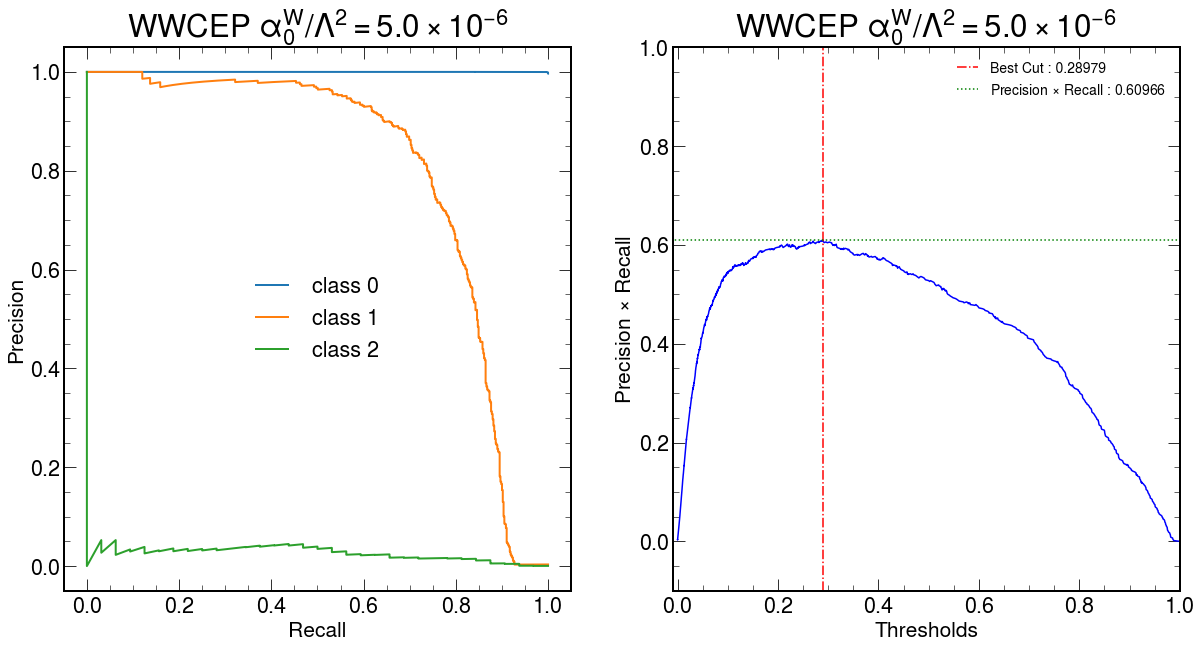

In [555]:
plot_precision_recall_curve(y_test8,predict_proba_LGBM8_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $' )


  Best Cut  0.0023456475659391885 



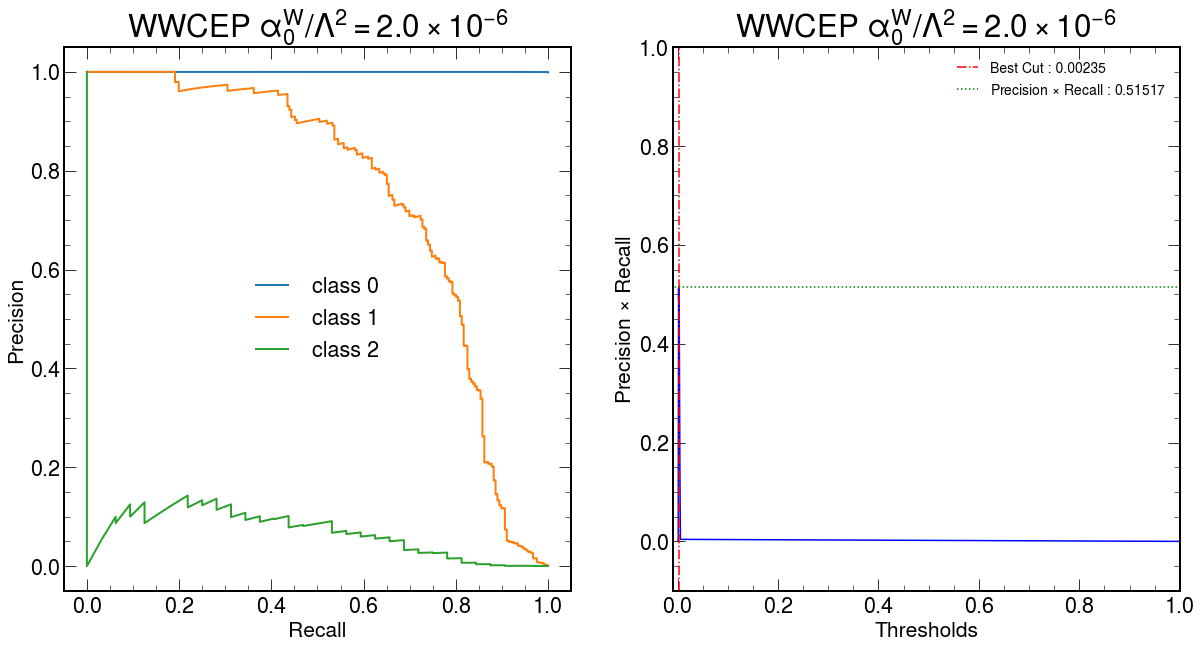

In [556]:
plot_precision_recall_curve(y_test7,predict_proba_LGBM7_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $' )


  Best Cut  0.3582636293385993 



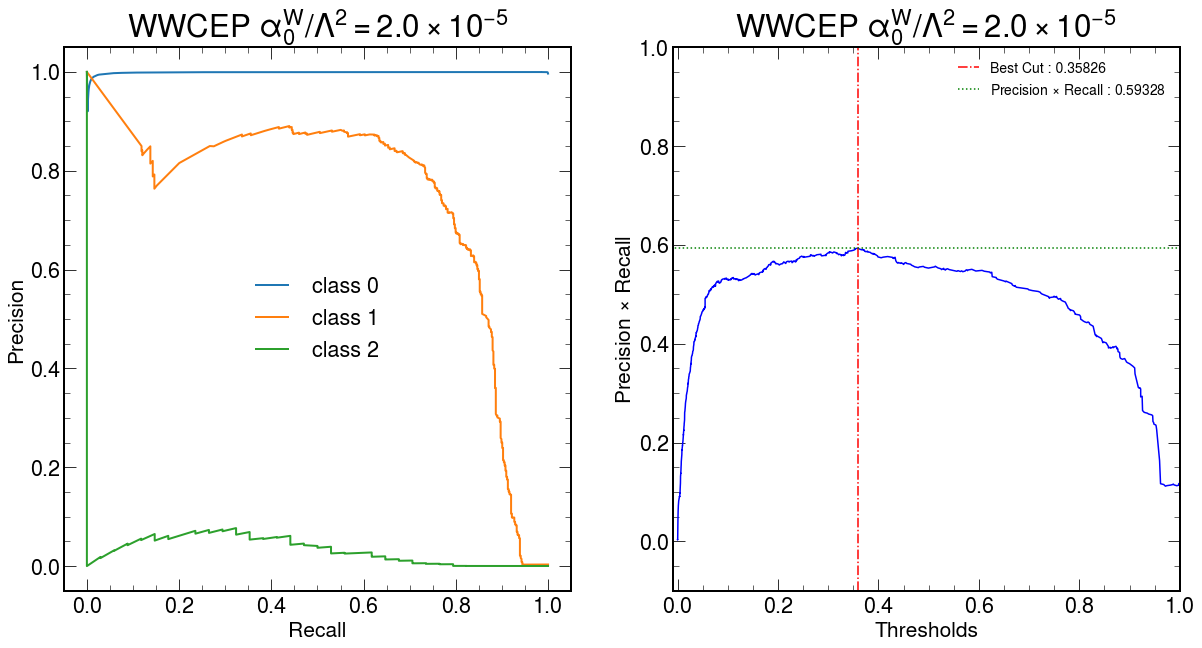

In [557]:
plot_precision_recall_curve(y_test1,predict_proba_LGBM1_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-5} $' )


  Best Cut  0.0 



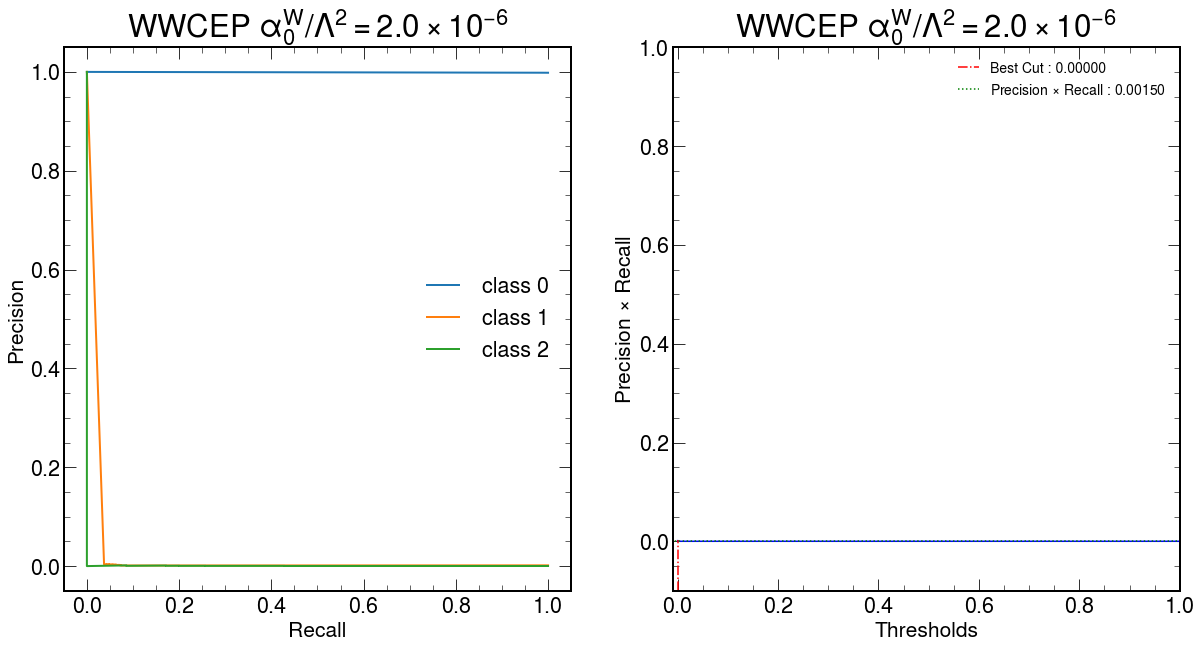

In [558]:
plot_precision_recall_curve(y_test4,predict_proba_LGBM4_binary_logloss_scale_pos_weight, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $' )

In [559]:
def plot_probab(bst, predict, label, label_anomalo, weight_back, weight_sig, weight_SM):
  predict_dados = bst.predict(data_set_dados_multirp)[:,1]
  bins = 25
  plt.figure(figsize = (15,10))

  hbgt_lgb = plt.hist( predict[ label == 0 ][:,1], bins = np.linspace(0,1,bins), alpha = 1, histtype = 'bar', color = 'pink', label = 'Background', weights = weight_back/test_size )
  plt.hist( predict[ label == 1 ][:,1], bins = np.linspace(0,1,bins), ls='-', linewidth=2.5, histtype = 'step', label = label_anomalo, weights = weight_sig/test_size, color = 'green' )
  plt.hist( predict[ label == 2 ][:,1], bins = np.linspace(0,1,bins), ls='--', linewidth=2.5, histtype = 'step', label = 'Standar Model', weights = weight_SM/test_size, color = 'blue' )

  uppery_lgb=np.max(hbgt_lgb[0])
  plt.plot( [ best_cut(label,predict),best_cut(label,predict)],[0,uppery_lgb],"-.r", linewidth=2.5,  label='Best cut : {:2.3f}'.format( best_cut(label,predict) ) )
  
  counts_1, bin_edges_1 = np.histogram( predict_dados[ predict_dados < best_cut(label,predict) ] , bins = np.linspace(0,1,bins) )
  errors_1 = np.sqrt( counts_1 )
  bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
  plt.errorbar( bin_centres_1, counts_1, yerr=errors_1, xerr=abs(bin_centres_1[1] - bin_centres_1[2])/2, fmt='.', label = 'Data-2016', color = 'black' )

  n_events_back_after_cut = predict[ label == 0 ][:,1][predict[ label == 0 ][:,1] > best_cut(label,predict )].shape[0]
  n_events_signal_after_cut = predict[ label == 1 ][:,1][predict[ label == 1 ][:,1] > best_cut(label,predict )].shape[0]
  n_events_SM_after_cut = predict[ label == 2 ][:,1][predict[ label == 2 ][:,1] > best_cut(label,predict )].shape[0]

  print('Numero de eventos de background depois do corte -->', n_events_back_after_cut)
  print('Numero de eventos de signal depois do corte -->', n_events_signal_after_cut)
  print('Numero de eventos de SM depois do corte -->', n_events_SM_after_cut)

  plt.xlabel( "Probability" )
  plt.ylabel( "Events" )
  plt.title( "Monte-Carlo Test" )
  plt.legend( loc = "upper right", fontsize = 16 )
  plt.yscale( 'log' )

Numero de eventos de background depois do corte --> 43
Numero de eventos de signal depois do corte --> 407
Numero de eventos de SM depois do corte --> 11


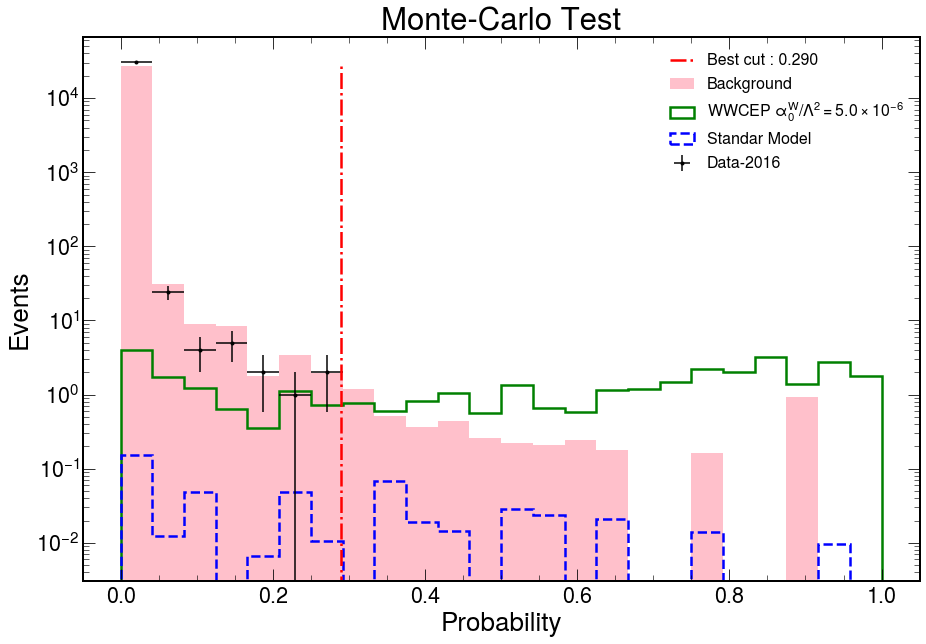

In [560]:
plot_probab(bst8_binary_logloss_scale_pos_weight, predict_proba_LGBM8_binary_logloss_scale_pos_weight, y_test8, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 5.0 \times 10^{-6} $', DataSet_Test8_weight_backgr, DataSet_Test8_weight_signal, DataSet_TestSM8_weight_signal )

Numero de eventos de background depois do corte --> 31
Numero de eventos de signal depois do corte --> 159
Numero de eventos de SM depois do corte --> 11


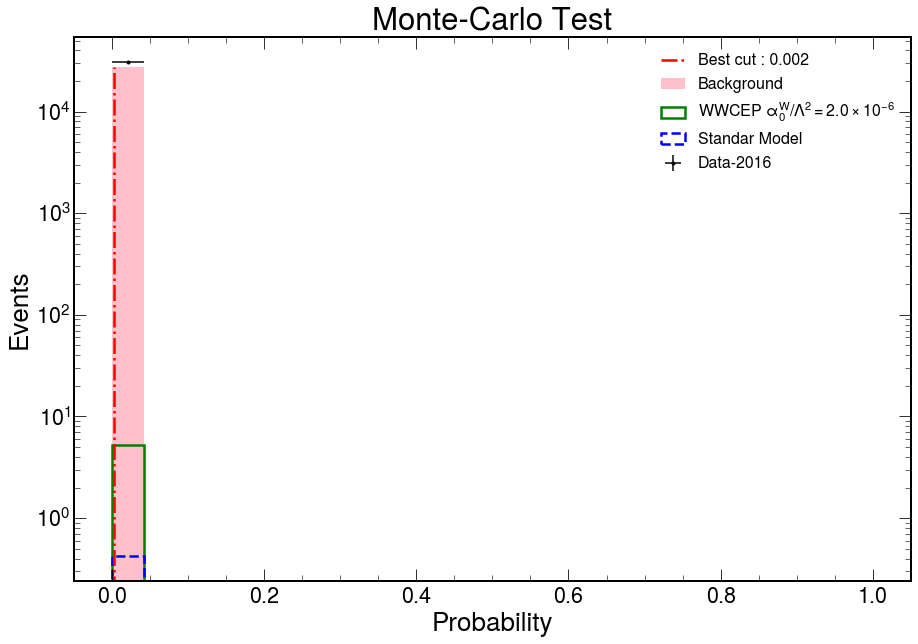

In [561]:
plot_probab(bst7_binary_logloss_scale_pos_weight, predict_proba_LGBM7_binary_logloss_scale_pos_weight, y_test7, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-6} $', DataSet_Test7_weight_backgr, DataSet_Test7_weight_signal, DataSet_TestSM7_weight_signal )

Numero de eventos de background depois do corte --> 77
Numero de eventos de signal depois do corte --> 418
Numero de eventos de SM depois do corte --> 21


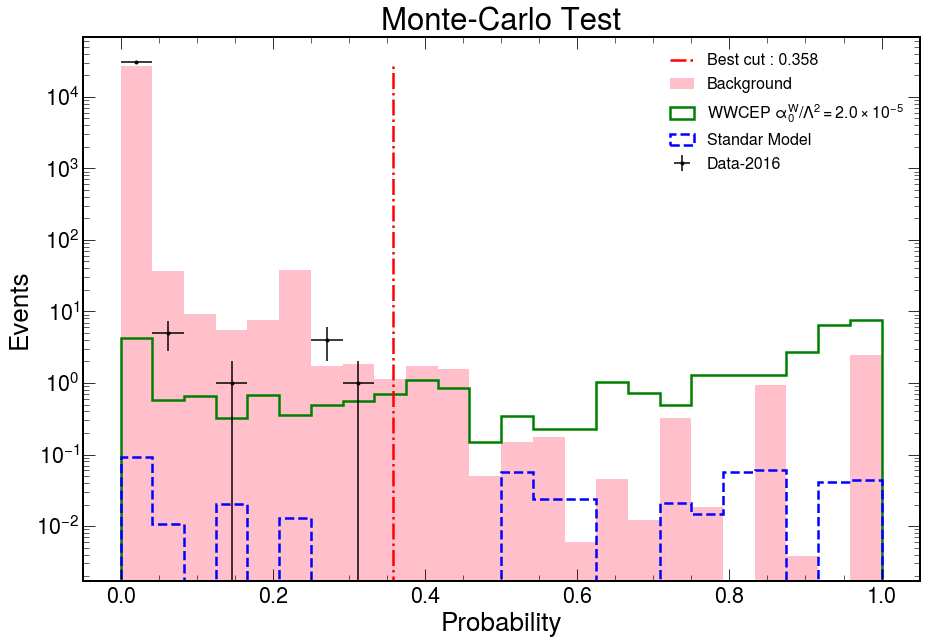

In [562]:
plot_probab(bst1_binary_logloss_scale_pos_weight, predict_proba_LGBM1_binary_logloss_scale_pos_weight, y_test1, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 2.0 \times 10^{-5} $', DataSet_Test1_weight_backgr, DataSet_Test1_weight_signal, DataSet_TestSM1_weight_signal )

Numero de eventos de background depois do corte --> 27426
Numero de eventos de signal depois do corte --> 37
Numero de eventos de SM depois do corte --> 4


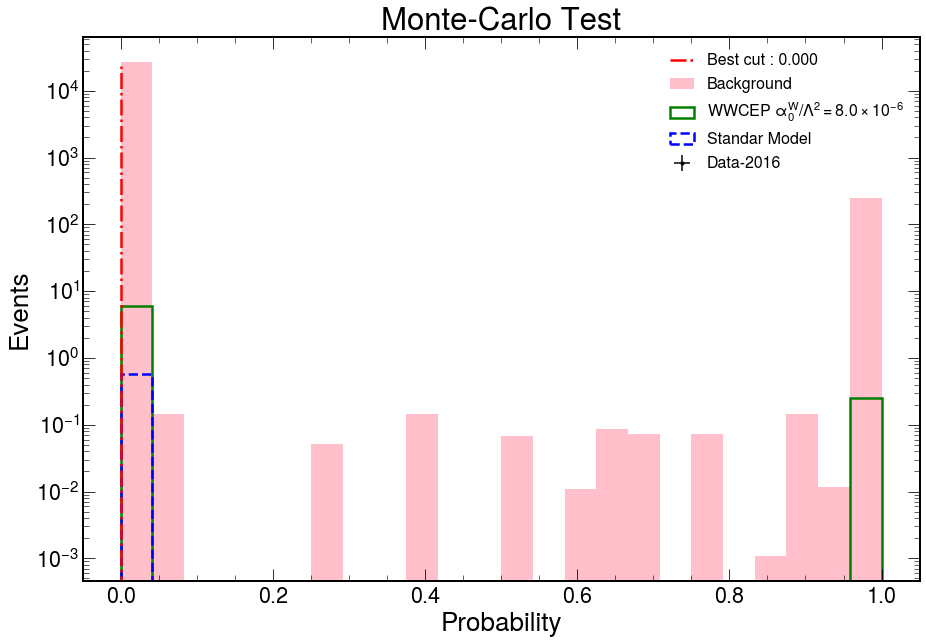

In [563]:
plot_probab(bst4_binary_logloss_scale_pos_weight, predict_proba_LGBM4_binary_logloss_scale_pos_weight, y_test4, r'WWCEP $\alpha_{0}^{W}/\Lambda^{2} = 8.0 \times 10^{-6} $', DataSet_Test4_weight_backgr, DataSet_Test4_weight_signal, DataSet_TestSM4_weight_signal )